<img src="Accuriod_image.png" width="100" height="100" align="right"/>

# Project Accuriod

**Health Hackathon - Chicago 2019**
<br>Team “The Novices”

*Technical report [DRAFT]*

## Table of contents
- [Document description](#section_1)
- [Data imports and workbook configuration](#section_2)
- [Exploratory Data Analysis](#section_3)
- [Feature engineering](#section_4)
- [Modelling](#section_5)
- [Conclusions](#section_6)


### **Document description:**<a id="section_1"></a>
This is a draft technical report that briefly explains the manipulations and initial data exploration made to the dataset #Challenge #4 of the Chicago HealthHackaton 2019. 

We highly reccomend to read this brief report in conjunction with the Project's PPT presentation.

As explained in such presentation, this project's work is preliminary. This technical report is intended to guide the reader through the thought process carried out by the team to come up with the proposed solution idea/proposition.

### Data imports and workbook configuration<a id="section_2"></a>
In this section we outline the initial code needed to run the analysis contained in this workbook. If this code returns an error we recommend the reader to verify that the most up to date version of the libraries mentioned below have been installed in their computers. For a guideline on python installation of modules please refer to the __[official documentation](https://docs.python.org/3/installing/)__.

In [2776]:
#Please run this cell to install the relevant modules for the workbook execution:

#Import relevant modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_rows', 100000)

#Add magic command to display visuals within the Jupyter notebook
%matplotlib inline

In [2777]:
#Run the following code to load the data

period = pd.read_csv("./datasets/Period.csv")
symptoms = pd.read_csv("./datasets/Symptom.csv")
user = pd.read_csv("./datasets/User.csv")

In [2778]:
#Define a mean fucntion to visualize certain means in our dataframes (see modelling section)
def new_mean(lst):
    counter = 0
    sums = 0
    for val in lst:
        if val > 0:
            counter += 1
            sums += val
    if (counter == 0):
        return 0
    else:
        return sums/counter

## Exploratory Data Analysis<a id="section_3"></a>
In this section we explore and celanse the data prior to model testing implementation.

We will display the head and the shapes of the datasets to have a sense of the data structure and the needed transformations.

In [2779]:
#We will run the following code to 
period.head()

,id,start_date,end_date,User_id
0,352,5/4/15,10/4/15,252
1,353,23/3/15,27/3/15,253
2,354,6/4/15,11/4/15,254
3,355,21/3/15,24/3/15,255
4,356,26/3/15,31/3/15,256


In [2780]:
symptoms.head()

,id,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date
0,127,252,0,0,0,0,0,0,0,0,0,0,11/4/15
1,128,257,0,0,0,46,0,0,0,0,0,0,10/4/15
2,129,257,0,0,0,0,0,27,48,0,0,0,11/4/15
3,130,263,0,0,0,0,0,0,0,0,0,0,11/4/15
4,132,269,0,0,0,0,0,0,0,0,0,0,11/4/15


In [2781]:
user.head()

,id,dob,cycle_length_initial,period_length_initial
0,252,NaN,28,6
1,253,NaN,30,5
2,254,NaN,28,6
3,255,NaN,30,4
4,256,NaN,25,6


In [2782]:
print('Shape of Period dataset: ',period.shape,'Symptom dataset: ', symptoms.shape,'User datset: ', user.shape)


Shape of Period dataset:  (34942, 4) Symptom dataset:  (13512, 13) User datset:  (6729, 4)


According to the readme file of the datasets we can infer the following:
- Period corresponds to user entries of period start date and end dates,
- Symptom corresponds to user entries of symptoms on a specific date, symptoms are rated from 0 to 100, being 0 having no symptoms at all and 100 having severe symptom presence,
- User is the onboarding data of the user to the app. Dob is the date of birth, id corresponds to user id and lengths are explressed in days.

In all the datasets (except for user) id represents the transaction id and user id is the unique user identifier in the App.


We will display in the following lines of code the datatypes of the datasets so we can make the appropiate transformations for modelling purposes:

In [2783]:
period.dtypes

id             int64
start_date    object
end_date      object
User_id        int64
dtype: object

In [2784]:
user.dtypes

id                        int64
dob                      object
cycle_length_initial      int64
period_length_initial     int64
dtype: object

In [2785]:
symptoms.dtypes

id           int64
user_id      int64
acne         int64
backache     int64
bloating     int64
cramp        int64
diarrhea     int64
dizzy        int64
headache     int64
mood         int64
nausea       int64
sore         int64
date        object
dtype: object

It seems we only need to convert datatime series that are currently object into date time fields in order to manipulate them properly.

In [2786]:
#We create and test a function to convert datetime fields stored as object into actual datetime fields

date_format = "%d/%m/%Y"
def get_time(end,start):
    if ("-" in end):
        return 0
    else:
        ends = "20"+end.split("/")[2]
        news = "20"+end.split("/")[2]
        splitends = end.split("/")
        splitstarts = start.split("/")
        splitends[2] = ends
        splitstarts[2] = news
        end = "/".join(splitends)
        start = "/".join(splitstarts)
        days = (datetime.strptime(end,date_format) - datetime.strptime(start,date_format)).days
        if (days > 0 and days < 10):
            return days
        else:
            return 0
        
def convert_date(end):
    if ("-" in end):
        return 0
    date_format = "%m/%d/%Y"
    ends = "20"+end.split("/")[2]
    splitends = end.split("/")
    splitends[2] = ends
    temp = splitends[1]
    splitends[1] = splitends[0]
    splitends[0] = temp
    return datetime.strptime("/".join(splitends),date_format)

print(convert_date("19/8/15"))

2015-08-19 00:00:00


In [2787]:
#In this code block we apply the function to do the actual dataframe transformations
date_format = "%d/%m/%Y"
period = period.dropna(axis = 0,how='any')
period['P_time'] = period.apply(lambda x: get_time(x.end_date, x.start_date), axis=1)
period['start_date_2'] = period.apply(lambda x: convert_date(x.start_date), axis=1)
period['end_date_2'] = period.apply(lambda x: convert_date(x.end_date), axis=1)
symptoms['date_2'] = symptoms.apply(lambda x: convert_date(x.date), axis=1)

In [2788]:
symptoms.head()

,id,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date,date_2
0,127,252,0,0,0,0,0,0,0,0,0,0,11/4/15,2015-04-11 00:00:00
1,128,257,0,0,0,46,0,0,0,0,0,0,10/4/15,2015-04-10 00:00:00
2,129,257,0,0,0,0,0,27,48,0,0,0,11/4/15,2015-04-11 00:00:00
3,130,263,0,0,0,0,0,0,0,0,0,0,11/4/15,2015-04-11 00:00:00
4,132,269,0,0,0,0,0,0,0,0,0,0,11/4/15,2015-04-11 00:00:00


In [2789]:
period.head()

,id,start_date,end_date,User_id,P_time,start_date_2,end_date_2
0,352,5/4/15,10/4/15,252,5,2015-04-05 00:00:00,2015-04-10 00:00:00
1,353,23/3/15,27/3/15,253,4,2015-03-23 00:00:00,2015-03-27 00:00:00
2,354,6/4/15,11/4/15,254,5,2015-04-06 00:00:00,2015-04-11 00:00:00
3,355,21/3/15,24/3/15,255,3,2015-03-21 00:00:00,2015-03-24 00:00:00
4,356,26/3/15,31/3/15,256,5,2015-03-26 00:00:00,2015-03-31 00:00:00


In [2790]:
#Clean some dates that have an erroneous format
mask=period['end_date'].str.contains('-')
period=period[~mask]

In [2791]:
mask=symptoms['date'].str.contains('-')
symptoms=symptoms[~mask]
symptoms = symptoms.drop(columns = ['date'])

After doing the transformation we will go ahead and rename the columns, also drop the old columns that are objects.

In [2792]:
symptoms.rename(columns={'date_2':'date'},inplace=True)

In [2793]:
period.rename(columns={'start_date_2':'period_start_date',
                      'end_date_2':'period_end_date',
                      'User_id':'user_id'},inplace=True)

In [2794]:
period.dtypes

id                    int64
start_date           object
end_date             object
user_id               int64
P_time                int64
period_start_date    object
period_end_date      object
dtype: object

In order to analyze all datasets together we will merge them based on user id, month and year where each one of these entries represents a cycle. We will call this 'unique id'.

In [2795]:
period['period_end_date']=period['period_end_date'].astype(str)

period['month']=period['period_end_date'].apply(lambda x: x[5:7]).astype(str)
period['year']=period['period_end_date'].apply(lambda x: x[:4]).astype(str)

period.drop(['start_date','end_date'],axis=1,inplace=True)

In [2796]:
period['unique_id']=period['user_id'].astype(str)+"-"+period['month']+"-"+period['year']

In [2797]:
period.head()

,id,user_id,P_time,period_start_date,period_end_date,month,year,unique_id
0,352,252,5,2015-04-05 00:00:00,2015-04-10 00:00:00,04,2015,252-04-2015
1,353,253,4,2015-03-23 00:00:00,2015-03-27 00:00:00,03,2015,253-03-2015
2,354,254,5,2015-04-06 00:00:00,2015-04-11 00:00:00,04,2015,254-04-2015
3,355,255,3,2015-03-21 00:00:00,2015-03-24 00:00:00,03,2015,255-03-2015
4,356,256,5,2015-03-26 00:00:00,2015-03-31 00:00:00,03,2015,256-03-2015


In [2798]:
symptoms['date']=symptoms['date'].astype(str)

symptoms['month']=symptoms['date'].apply(lambda x: x[5:7]).astype(str)
symptoms['year']=symptoms['date'].apply(lambda x: x[:4]).astype(str)


In [2799]:
symptoms.head()

,id,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date,month,year
0,127,252,0,0,0,0,0,0,0,0,0,0,2015-04-11 00:00:00,04,2015
1,128,257,0,0,0,46,0,0,0,0,0,0,2015-04-10 00:00:00,04,2015
2,129,257,0,0,0,0,0,27,48,0,0,0,2015-04-11 00:00:00,04,2015
3,130,263,0,0,0,0,0,0,0,0,0,0,2015-04-11 00:00:00,04,2015
4,132,269,0,0,0,0,0,0,0,0,0,0,2015-04-11 00:00:00,04,2015


In [2800]:
symptoms['unique_id']=symptoms['user_id'].astype(str)+"-"+symptoms['month']+"-"+symptoms['year']

Now that we have the unique Ids we will proceed and pivot the dataset by this unique id in order to merge the symptoms data with the period data. We do this because there are more reported periods than symptoms.

In [2801]:
symptoms_new=pd.pivot_table(symptoms,
              index='unique_id',
              aggfunc=lambda x: new_mean(x))

symptoms_new.head()

,acne,backache,bloating,cramp,diarrhea,dizzy,headache,id,mood,nausea,sore,user_id
unique_id,,,,,,,,,,,,
1002-10-2015,0.0,28.0,28.0,30.000000,0.0,0.0,12.5,703.0,20.0,9.5,0.0,1002
1002-11-2015,0.0,28.0,0.0,79.000000,0.0,0.0,51.0,1019.0,100.0,0.0,0.0,1002
1002-12-2015,0.0,100.0,52.0,69.000000,0.0,0.0,52.0,1423.0,40.0,0.0,0.0,1002
1003-01-2016,26.0,9.0,0.0,72.000000,0.0,35.0,65.0,1831.0,0.0,0.0,0.0,1003
1003-10-2015,0.0,72.0,0.0,59.666667,54.0,50.0,73.5,740.5,0.0,41.0,1.0,1003


In [2802]:
symptoms_new.shape

(8620, 12)

In [2803]:
master_2=period.merge(symptoms_new,how='left',on='unique_id')
master_2.head()

,id_x,user_id_x,P_time,period_start_date,period_end_date,month,year,unique_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,id_y,mood,nausea,sore,user_id_y
0,352,252,5,2015-04-05 00:00:00,2015-04-10 00:00:00,04,2015,252-04-2015,50.0,50.0,0.0,0.0,0.0,0.0,0.0,146.666667,0.0,0.0,0.0,252.0
1,353,253,4,2015-03-23 00:00:00,2015-03-27 00:00:00,03,2015,253-03-2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,354,254,5,2015-04-06 00:00:00,2015-04-11 00:00:00,04,2015,254-04-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.000000,0.0,0.0,0.0,254.0
3,355,255,3,2015-03-21 00:00:00,2015-03-24 00:00:00,03,2015,255-03-2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,356,256,5,2015-03-26 00:00:00,2015-03-31 00:00:00,03,2015,256-03-2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2804]:
#We fill the nulls with 0s and drop the transaction id columns
master_2=master_2.fillna(0)

In [2805]:
master_2.drop(['id_x','id_y'],axis=1,inplace=True)

In [2806]:
user=user.rename(columns={'id':'user_id_x'})

In [2807]:
#We merge now with the user onboarding data and see the head preview of the dataframe
master_2=master_2.merge(user,how='left',on='user_id_x')
master_2.head()

,user_id_x,P_time,period_start_date,period_end_date,month,year,unique_id,acne,backache,bloating,...,diarrhea,dizzy,headache,mood,nausea,sore,user_id_y,dob,cycle_length_initial,period_length_initial
0,252,5,2015-04-05,2015-04-10 00:00:00,04,2015,252-04-2015,50.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,252.0,NaN,28,6
1,253,4,2015-03-23,2015-03-27 00:00:00,03,2015,253-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30,5
2,254,5,2015-04-06,2015-04-11 00:00:00,04,2015,254-04-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,254.0,NaN,28,6
3,255,3,2015-03-21,2015-03-24 00:00:00,03,2015,255-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30,4
4,256,5,2015-03-26,2015-03-31 00:00:00,03,2015,256-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,25,6


In [2808]:
#We inspect the shape to verify it is alright
master_2.shape

(32163, 21)

In [2809]:
#Drop unnecessary ids
master_2.drop(['user_id_y'],axis=1,inplace=True)

In [2810]:
master_2=master_2.rename(columns={'user_id_x':'User_id'})

In [2811]:
#Sort values by user id and reported period end date and inspect the head
master_2=master_2.sort_values(by=['User_id','period_end_date'],ascending=[True,True])

In [2812]:
master_2.head(10)

,User_id,P_time,period_start_date,period_end_date,month,year,unique_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,dob,cycle_length_initial,period_length_initial
0,252,5,2015-04-05,2015-04-10 00:00:00,04,2015,252-04-2015,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,6
1,253,4,2015-03-23,2015-03-27 00:00:00,03,2015,253-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30,5
2,254,5,2015-04-06,2015-04-11 00:00:00,04,2015,254-04-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,6
6380,254,5,2016-04-24,2016-04-29 00:00:00,04,2016,254-04-2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,6
9211,254,5,2016-06-22,2016-06-27 00:00:00,06,2016,254-06-2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,6
3,255,3,2015-03-21,2015-03-24 00:00:00,03,2015,255-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30,4
4,256,5,2015-03-26,2015-03-31 00:00:00,03,2015,256-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,25,6
5,257,5,2015-03-10,2015-03-15 00:00:00,03,2015,257-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,30,6
6,257,4,2015-04-11,2015-04-15 00:00:00,04,2015,257-04-2015,0.0,0.0,0.0,46.0,0.0,27.0,47.5,0.0,0.0,0.0,NaN,30,6
7,258,4,2015-03-11,2015-03-15 00:00:00,03,2015,258-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,5


During the merging process we identified that there were certain values that reported no stat or end dates, so we remove them from our analysis to reduce the noise in the data.

In [2813]:
mask=master_2['period_start_date']=='0'
master_2=master_2[~mask]

In [2814]:
master_2.dtypes

User_id                           int64
P_time                            int64
period_start_date        datetime64[ns]
period_end_date                  object
month                            object
year                             object
unique_id                        object
acne                            float64
backache                        float64
bloating                        float64
cramp                           float64
diarrhea                        float64
dizzy                           float64
headache                        float64
mood                            float64
nausea                          float64
sore                            float64
dob                              object
cycle_length_initial              int64
period_length_initial             int64
dtype: object

## Feature engineering<a id="section_4"></a>
We will compute in this section of the code a field that shows the deviations from the actual period time reported with the initial period time.We will do the same calculation for cycle. This in order to inspect if fluctuations in the cycle can be clustered with symtoms. (see modelling below).

In [2815]:
#Create period deviations
master_2.drop(['dob'],axis=1,inplace=True)
master_2['period_end_date']=pd.to_datetime(master_2['period_end_date'])
master_2['period_deviations']=master_2['period_length_initial']-master_2['P_time']

In [2816]:
#Calculate cycle in days
master_2['next_User_id']=master_2['User_id'].shift(-1)
master_2['next_period_start_date']=master_2['period_start_date'].shift(-1)
master_2['cycle']=master_2['next_period_start_date']-master_2['period_end_date']
master_2['cycle']=master_2['cycle'].dt.days

master_2.head(10)

,User_id,P_time,period_start_date,period_end_date,month,year,unique_id,acne,backache,bloating,...,headache,mood,nausea,sore,cycle_length_initial,period_length_initial,period_deviations,next_User_id,next_period_start_date,cycle
0,252,5,2015-04-05,2015-04-10,04,2015,252-04-2015,50.0,50.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,253.0,2015-03-23,-18.0
1,253,4,2015-03-23,2015-03-27,03,2015,253-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30,5,1,254.0,2015-04-06,10.0
2,254,5,2015-04-06,2015-04-11,04,2015,254-04-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,254.0,2016-04-24,379.0
6380,254,5,2016-04-24,2016-04-29,04,2016,254-04-2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,254.0,2016-06-22,54.0
9211,254,5,2016-06-22,2016-06-27,06,2016,254-06-2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,255.0,2015-03-21,-464.0
3,255,3,2015-03-21,2015-03-24,03,2015,255-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30,4,1,256.0,2015-03-26,2.0
4,256,5,2015-03-26,2015-03-31,03,2015,256-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,25,6,1,257.0,2015-03-10,-21.0
5,257,5,2015-03-10,2015-03-15,03,2015,257-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30,6,1,257.0,2015-04-11,27.0
6,257,4,2015-04-11,2015-04-15,04,2015,257-04-2015,0.0,0.0,0.0,...,47.5,0.0,0.0,0.0,30,6,2,258.0,2015-03-11,-35.0
7,258,4,2015-03-11,2015-03-15,03,2015,258-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,5,1,258.0,2015-04-11,27.0


Now we will limit our data in order to analyze our sample of interest, individuals that have:
- Reported two or more continious periods
- Reported at least one symptom


In [2817]:
#Mask dataframe for only users with at least 3 entries
mask=master_2['next_User_id']==master_2['User_id']
m1=master_2[mask]
m2=master_2[~mask]
m1.head(10)

,User_id,P_time,period_start_date,period_end_date,month,year,unique_id,acne,backache,bloating,...,headache,mood,nausea,sore,cycle_length_initial,period_length_initial,period_deviations,next_User_id,next_period_start_date,cycle
2,254,5,2015-04-06,2015-04-11,04,2015,254-04-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,254.0,2016-04-24,379.0
6380,254,5,2016-04-24,2016-04-29,04,2016,254-04-2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,6,1,254.0,2016-06-22,54.0
5,257,5,2015-03-10,2015-03-15,03,2015,257-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30,6,1,257.0,2015-04-11,27.0
7,258,4,2015-03-11,2015-03-15,03,2015,258-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,5,1,258.0,2015-04-11,27.0
12,262,4,2015-03-10,2015-03-14,03,2015,262-03-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,5,1,262.0,2015-04-12,29.0
26,262,4,2015-04-12,2015-04-16,04,2015,262-04-2015,51.0,0.0,45.0,...,0.0,53.0,0.0,0.0,28,5,1,262.0,2015-09-16,153.0
18,269,7,2015-04-04,2015-04-11,04,2015,269-04-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,8,1,269.0,2015-08-28,139.0
160,269,6,2015-08-28,2015-09-03,09,2015,269-09-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,8,2,269.0,2015-10-01,28.0
773,269,5,2015-10-01,2015-10-06,10,2015,269-10-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,8,3,269.0,2015-12-02,57.0
2163,269,5,2015-12-02,2015-12-07,12,2015,269-12-2015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28,8,3,269.0,2016-01-04,28.0


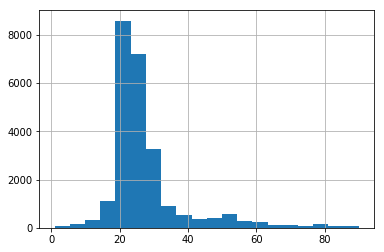

In [2818]:
#Eliminate extreme outliers and review distribution
mask=(m1['cycle']>0) & (m1['cycle']<91)
m1=m1[mask]
m1['cycle'].hist(bins=20);

In [2819]:
#Calculate cycle deviations with dataset that excludes extreme outliers
m1['cycle_deviations']=m1['cycle_length_initial']-m1['cycle']

In [2820]:
#Create dummy variable to filter only observations that report symptoms
m1['has_symptoms']=m1[['acne', 'backache', 'bloating', 'cramp','diarrhea', 'dizzy', 'headache', 'mood', 'nausea', 'sore']].sum(axis=1)
m1['has_symptoms']=m1['has_symptoms'].apply(lambda x: 1 if x>0 else 0)
m1['has_symptoms'].value_counts()

0    20118
1     4526
Name: has_symptoms, dtype: int64

In [2821]:
#Mask df for symptom data only
mask=m1['has_symptoms']==1
m1=m1[mask]
m1.shape

(4526, 25)

## Modelling<a id="section_5"></a>
Now that the dataset is clean we will import KMeans clustering algorythm to test it in our data.

In [2849]:
from sklearn.cluster import KMeans

In [2851]:
#We select relevant features

features=['P_time',
#           'cycle_length_initial',
#           'period_length_initial',
#           'period_deviations',
          'cycle', 
#           'cycle_deviations',
#           'has_symptoms']
         ]

#Set predictors
X=m1[features]

In [2852]:
#Instantiate and fit the model
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

In [2853]:
#Predict clusters
predictions=kmeans.predict(X)

In [2854]:
#Add predictions to original dataframe
m1['cluster']=pd.DataFrame(predictions)

In [2855]:
#Display table summarizing symptoms by identified cluster
sym_lst=['acne', 'backache', 'bloating', 'cramp',
                       'diarrhea', 'dizzy', 'headache', 'mood', 'nausea', 'sore']
#                       'P_time','cycle']

table=pd.pivot_table(m1,
              index='cluster',
               values=sym_lst,
              aggfunc=lambda x: new_mean(x))

table['sum']=table.sum(axis=1)
table=table.sort_values(by='sum')
table.drop('sum',axis=1,inplace=True)
table

,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
cluster,,,,,,,,,,
0.0,39.528675,45.712117,48.197182,51.333780,36.408240,38.709555,41.441493,50.526830,40.038528,49.152428
2.0,34.023055,52.855857,52.001635,53.309020,45.989744,40.809877,44.377679,53.996236,38.273056,46.704412
1.0,32.059524,50.065972,61.876344,57.693694,43.833333,37.800000,42.108696,45.560000,42.740741,50.284091
3.0,22.857143,54.895833,60.312500,62.550000,33.250000,100.000000,56.600000,39.214286,55.250000,59.500000


In [2856]:
#Display table showing period time, cycle and cycle deviation by cluster
pd.pivot_table(m1,
              index='cluster',
               values=['P_time','cycle','cycle_deviations'],
              aggfunc=lambda x: new_mean(x))

,P_time,cycle,cycle_deviations
cluster,,,
0.0,4.681416,27.212465,6.086142
1.0,4.428571,28.882353,5.685714
2.0,4.584475,26.376623,6.193182
3.0,3.941176,26.722222,4.916667


In [2857]:
#Count predicted cluster values
m1['cluster'].value_counts()

#Notice thatthe algorythm predicts very few datapoints - further review needs to be made to determine 
#why the 4k observations are not being predicted (time did not permit)

0.0    353
2.0    231
1.0     51
3.0     18
Name: cluster, dtype: int64

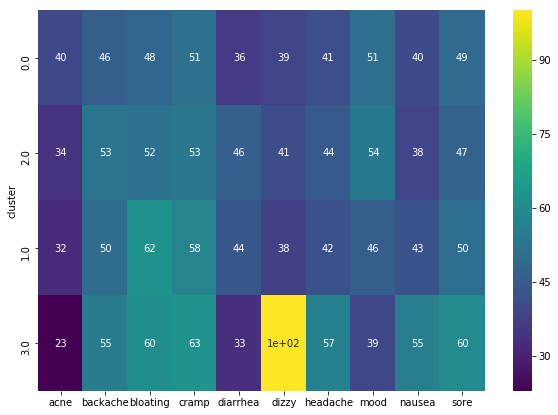

In [2858]:
#Plot color blind heatmap  showing clusters and symptoms colored by severness
plt.figure(figsize=(10,7))

sns.heatmap(table,
           cmap='viridis',
           annot=True);

## Conclusions<a id="section_6"></a>
We can conclude that seems that based in the clustering algorythms tested above it might be viable to improve the clustering algoryhtm with additional quality data.

As explained in the PPT presentation next steps involve:
- improving data quality
- testing clustering algorythm with cross validation and train test splits
- grid searching and pipeline into clustering algorythm

Data issues / challenges encountered in our pilot test:
- Users do not report symptoms (incomplete data) ~ 4,690 obs. used from ~32k data points
- No demographic and physiological data to cluster users.
- User subjectivity when reporting symptoms
